# 🌍 Introduction to GeoPandas
GeoPandas เป็นไลบรารีที่ขยาย Pandas เพื่อรองรับข้อมูลเชิงพื้นที่ โดยสามารถจัดการและวิเคราะห์ข้อมูลภูมิศาสตร์ได้ง่าย

## 📌 1. ติดตั้งและ Import ไลบรารี

In [ ]:
!pip install geopandas shapely matplotlib fiona contextily -q

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon

## 📌 2. ความแตกต่างระหว่าง Pandas และ GeoPandas

In [ ]:
# สร้าง DataFrame ปกติด้วย Pandas
df = pd.DataFrame({
    'City': ['Bangkok', 'Chiang Mai', 'Phuket'],
    'Population': [10539000, 1272400, 416582]
})
display(df)

,City,Population
0,Bangkok,10539000
1,Chiang Mai,1272400
2,Phuket,416582


In [ ]:
# สร้าง GeoDataFrame ด้วย GeoPandas
geometry = [Point(100.5018, 13.7563), Point(98.9931, 18.7883), Point(98.3858, 7.8804)]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
display(gdf)

,City,Population,geometry
0,Bangkok,10539000,POINT (100.5018 13.7563)
1,Chiang Mai,1272400,POINT (98.9931 18.7883)
2,Phuket,416582,POINT (98.3858 7.8804)


## 📌 3. การอ่านและเขียนไฟล์ GeoData (Shapefile, GeoJSON)

In [ ]:
import fiona

shapefile_path = "/content/TH_Province.shp"

with fiona.open(shapefile_path) as src:
    print(src.schema)

{'properties': {'PROV_CODE': 'str:2', 'PROV_NAMT': 'str:80', 'PROV_NAME': 'str:80', 'Area_km2_': 'float:11.2'}, 'geometry': 'Polygon'}


In [ ]:
import geopandas as gpd
import fiona

shapefile_path = "/content/TH_Province.shp"

# Load the shapefile as a GeoDataFrame
gdf_shp = gpd.read_file(shapefile_path) # Read the shapefile using GeoPandas


# Specify the virtual file system to read from the zip archive
with fiona.open(shapefile_path) as src:
    print(src.schema)  # แสดงโครงสร้างของไฟล์

# บันทึกเป็น GeoJSON
gdf_shp.to_file("world.geojson", driver="GeoJSON")

{'properties': {'PROV_CODE': 'str:2', 'PROV_NAMT': 'str:80', 'PROV_NAME': 'str:80', 'Area_km2_': 'float:11.2'}, 'geometry': 'Polygon'}


## 📌 4. การแสดงผลข้อมูลเชิงพื้นที่ด้วย .plot()

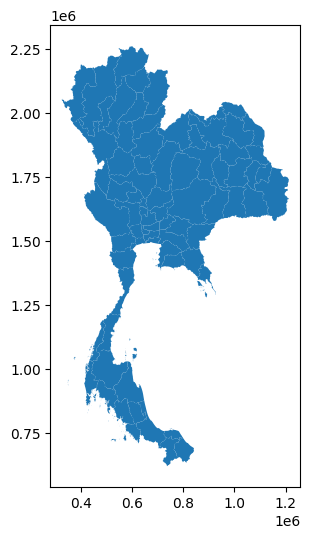

In [ ]:
gdf_shp.plot(figsize=(10,6))
plt.show()

## 📌 5. Spatial Operations พื้นฐาน

1. สร้างจุดสถานที่สำคัญ เช่น Grand Palace พร้อมพิกัด Latitude, Longitude
2. สร้าง Geometry ของจุด โดยใช้ shapely.geometry.Point
3. แปลงเป็น GeoDataFrame และกำหนดระบบพิกัด EPSG:4326 (WGS84)
4. เปลี่ยนพิกัดเป็น EPSG:32647 (UTM Zone 47N - Thailand)
เพราะ buffer() ใช้หน่วย "เมตร", เราต้องใช้พิกัดที่มีหน่วยเป็นเมตรก่อน
5. สร้าง Buffer รัศมี 10 กิโลเมตร (10,000 เมตร) รอบแต่ละจุด
6. แปลงกลับเป็น EPSG:4326 เพื่อให้ใช้งานกับแผนที่ออนไลน์ได้
7. Plot ผลลัพธ์ โดยแสดง:
พื้นที่ Buffer (สีฟ้า)
จุดสถานที่สำคัญ (สีแดง)

/tmp/ipython-input-1169556450.py:38: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


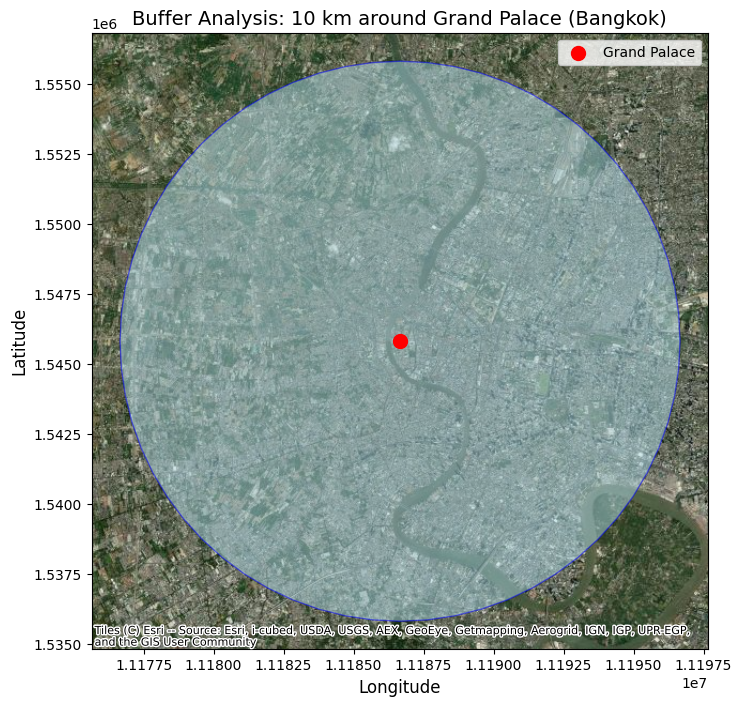

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx  # ไลบรารีสำหรับเพิ่มแผนที่พื้นหลัง

# สร้างจุดเดียวคือ Grand Palace
data = {
    'place': ['Grand Palace'],
    'latitude': [13.7525],
    'longitude': [100.4913]
}

# สร้าง Geometry ของจุด
geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]

# แปลงเป็น GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

# แปลง CRS เป็น Web Mercator (EPSG:3857) เพื่อใช้กับแผนที่พื้นหลัง
gdf = gdf.to_crs("EPSG:3857")

# สร้าง Buffer รัศมี 10,000 เมตร (10 km) รอบ Grand Palace
gdf["buffer"] = gdf.geometry.buffer(10000)

# 📌 Plot แสดงผล Buffer พร้อมพื้นหลังเป็นภาพถ่ายดาวเทียม
fig, ax = plt.subplots(figsize=(10, 8))

# Plot Buffer
gdf.set_geometry("buffer").plot(ax=ax, color="lightblue", alpha=0.5, edgecolor="blue", linewidth=1, label="Buffer 10 km")

# Plot จุด Grand Palace
gdf.set_geometry("geometry").plot(ax=ax, color="red", markersize=100, label="Grand Palace")

# เพิ่มแผนที่พื้นหลังจาก Contextily (Satellite Image)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

# ตั้งค่ากราฟให้ดูสวยขึ้น
plt.legend()
plt.title("Buffer Analysis: 10 km around Grand Palace (Bangkok)", fontsize=14)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.show()


## 📌 6. Spatial Join (sjoin)

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# 📌 โหลดข้อมูลขอบเขตจังหวัดไทยจากไฟล์ Shapefile
# Replace 'path/to/TH_Province.shp' with the actual path to your shapefile
th_province_path = "/content/TH_Province.shp"  # เปลี่ยนเป็นพาธของคุณ
gdf_province = gpd.read_file(th_province_path)

# 📌 สร้างจุดของ Grand Palace
data = {
    'place': ['Grand Palace'],
    'latitude': [13.7525],
    'longitude': [100.4913]
}

# แปลงเป็น GeoDataFrame
geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]
gdf_point = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

# 📌 แปลง CRS ให้ตรงกัน (ใช้ EPSG:4326)
gdf_province = gdf_province.to_crs("EPSG:4326")

# 📌 ทำ Spatial Join เพื่อตรวจสอบว่า Grand Palace อยู่ในจังหวัดไหน
gdf_joined = gpd.sjoin(gdf_point, gdf_province, how='left', predicate='intersects')

# แสดงผลลัพธ์
# Replace 'province_name' with the actual name of the province column in your shapefile
# Print the columns of gdf_joined to see the available column names
print(gdf_joined.columns)
# Access the correct column name for province (e.g., 'PROV_NAMT')
display(gdf_joined[['place', 'geometry', 'PROV_NAMT']])  # เปลี่ยน 'province_name' เป็นชื่อคอลัมน์จังหวัดจริงๆ

Index(['place', 'latitude', 'longitude', 'geometry', 'index_right',
       'PROV_CODE', 'PROV_NAMT', 'PROV_NAME', 'Area_km2_'],
      dtype='object')


,place,geometry,PROV_NAMT
0,Grand Palace,POINT (100.4913 13.7525),กรุงเทพมหานคร


# 🎯 แบบฝึกหัด GeoPandas
ลองทำแบบฝึกหัดต่อไปนี้เพื่อฝึกใช้ GeoPandas ในการวิเคราะห์ข้อมูลเชิงพื้นที่

## ✏️ แบบฝึกหัดที่ 1: การสร้าง GeoDataFrame
**โจทย์:**
1. สร้าง DataFrame ของเมือง 3 เมืองในประเทศไทย พร้อมพิกัด Latitude และ Longitude
2. ใช้ GeoPandas แปลงข้อมูลเป็น GeoDataFrame และแสดงผล


In [ ]:
# 🔥 เขียนโค้ดที่นี่
import geopandas as gpd
from shapely.geometry import Point

# TODO: สร้าง DataFrame ของ 3 เมือง พร้อมพิกัด
# city_data = ???

# TODO: แปลงเป็น GeoDataFrame และแสดงผล
# gdf = ???
# display(gdf)

## ✏️ แบบฝึกหัดที่ 2: การสร้าง Buffer และวิเคราะห์พื้นที่รอบจุด
**โจทย์:**
1. ใช้ข้อมูลจุด (Point) ที่สร้างจากแบบฝึกหัดที่ 1
2. สร้าง Buffer รัศมี 50 กิโลเมตรรอบแต่ละจุด
3. แสดงผล Buffer บนแผนที่

In [ ]:
# 🔥 เขียนโค้ดที่นี่
import geopandas as gpd

# TODO: ใช้ข้อมูลจากแบบฝึกหัดที่ 1
# gdf = ???

# TODO: สร้าง Buffer รัศมี 50 กิโลเมตร
# gdf['buffer'] = ???

# TODO: แสดงผล Buffer บนแผนที่
# gdf.plot(column='buffer', cmap='coolwarm', legend=True)
# plt.show()

# ✅ เฉลยแบบฝึกหัด GeoPandas
นี่คือคำตอบของแบบฝึกหัดแต่ละข้อ

## ✏️ เฉลยแบบฝึกหัดที่ 1: การสร้าง GeoDataFrame

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# สร้าง DataFrame ของ 3 เมืองในประเทศไทย
city_data = {
    'City': ['Bangkok', 'Chiang Mai', 'Phuket'],
    'Latitude': [13.7563, 18.7883, 7.8804],
    'Longitude': [100.5018, 98.9931, 98.3858]
}

# สร้าง Geometry ของจุด
geometry = [Point(xy) for xy in zip(city_data['Longitude'], city_data['Latitude'])]

# สร้าง GeoDataFrame
gdf = gpd.GeoDataFrame(city_data, geometry=geometry)
display(gdf)

,City,Latitude,Longitude,geometry
0,Bangkok,13.7563,100.5018,POINT (100.5018 13.7563)
1,Chiang Mai,18.7883,98.9931,POINT (98.9931 18.7883)
2,Phuket,7.8804,98.3858,POINT (98.3858 7.8804)


## ✏️ เฉลยแบบฝึกหัดที่ 2: การสร้าง Buffer และวิเคราะห์พื้นที่รอบจุด

/tmp/ipython-input-4226023068.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


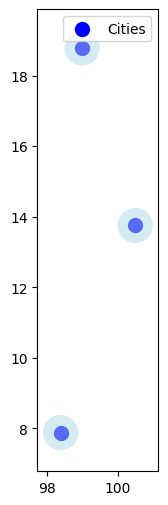

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# ใช้ข้อมูลจากแบบฝึกหัดที่ 1
gdf['buffer'] = gdf.geometry.buffer(0.5)  # Buffer 0.5 องศารอบแต่ละจุด

# แสดงผล Buffer บนแผนที่
fig, ax = plt.subplots(figsize=(8,6))
gdf.plot(ax=ax, color='blue', markersize=100, label='Cities')
gdf.set_geometry('buffer').plot(ax=ax, color='lightblue', alpha=0.5, label='Buffer 50 km')
plt.legend()
plt.show()